In [1]:
from data_mining import ImagePreProcessing
from data_visualization import SpikeViz
from spiking_neuron import Izhikevich

import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
num_neurons = 10
num_labels = 10
num_patterns = 1

ipp = ImagePreProcessing(dataset_patterns=x_train, 
                         dataset_labels=y_train,
                         patch_size=5,
                         patch_stride=1)
ipp.setMaxPatterns(val=num_patterns)
ipp.setMaxLabels(val=num_labels)

patches_per_label = ipp.run()
ipp.summary()

Dimensão (n x n) da imagem de entrada: n = 28
Dimensão (p x p) de cada patch(subset) da imagem: p = 5
Deslocamento da janela de extração de patches: 1
Quantidade de rótulos utilizados: 10
Quantidade de padrões utilizados: 1
Quantidade de patches extraídos por imagem: 529
Dimensão do conjunto de imagens, por rótulo: (10, 1, 28, 28)
Dimensões do conjunto de patches (Entrada para SNN): (10, 1, 529, 5, 5)


## Definição da camada de neurônios, pesos sinápticos e intensidade por patch:

In [4]:
patches_per_label.shape

(10, 1, 529, 5, 5)

In [5]:
W = np.random.uniform(0, 1, (num_labels, num_patterns, num_neurons, ipp.patches_ds.shape[2], ipp.patch_size, ipp.patch_size))

In [6]:
intensity_per_neuron = np.zeros((num_labels, num_patterns, num_neurons))
gama = 0.01

for label in range(num_labels):
    for pattern in range(num_patterns):
        for neuron in range(num_neurons):
            total_int = 0
            for patch in range(ipp.patches_ds.shape[2]):
                patch_int = 0
                for i in range(ipp.patch_size):
                    for j in range(ipp.patch_size):
                        patch_int += patches_per_label[label][pattern][patch][i][j]*W[label][pattern][neuron][patch][i][j]
                total_int += gama*patch_int
                patch_int = 0
            intensity_per_neuron[label][pattern][neuron] = total_int

## Converter as intensidades em correntes ao longo do tempo. Nesse caso, as correntes são constantes:

In [7]:
T = 100 
dt = 0.25
timeline = np.arange(0, T+dt, dt)
timeline.shape

(401,)

In [8]:
currents_per_neuron = np.zeros((num_labels, num_patterns, num_neurons, timeline.shape[0]))
for label in range(num_labels):
    for pattern in range(num_patterns):
        for neuron in range(num_neurons):
            for time_step in range(timeline.shape[0]):
                currents_per_neuron[label][pattern][neuron][time_step] = intensity_per_neuron[label][pattern][neuron]

## Instanciar uma camada de neurônios e aplicar a corrente em cada um:

In [9]:
neuron_layer = []
for i in range(num_neurons):
    neuron_layer.append(Izhikevich(neuron_type='RS'))

spike_train = np.zeros((num_labels, num_patterns, num_neurons, timeline.shape[0]))
spike_count = np.zeros((num_labels, num_patterns, num_neurons))
neurons_pot = np.zeros((num_labels, num_patterns, num_neurons, timeline.shape[0]))

for label in range(num_labels):
    for pattern in range(num_patterns):
        for neuron in range(num_neurons):
            I = currents_per_neuron[label][pattern][neuron]
            sc = neuron_layer[neuron].spikeResponse(I, dt, spike_train[label][pattern][neuron], neurons_pot[label][pattern][neuron])
            spike_count[label][pattern][neuron] = sc
            neuron_layer[neuron].setNeuronBaseProperties()
    



## Visualização dos resultados: Contagem de spikes, Spike Train, Potencial

In [10]:
spkViz = SpikeViz(original_image=ipp.patlab_ds)

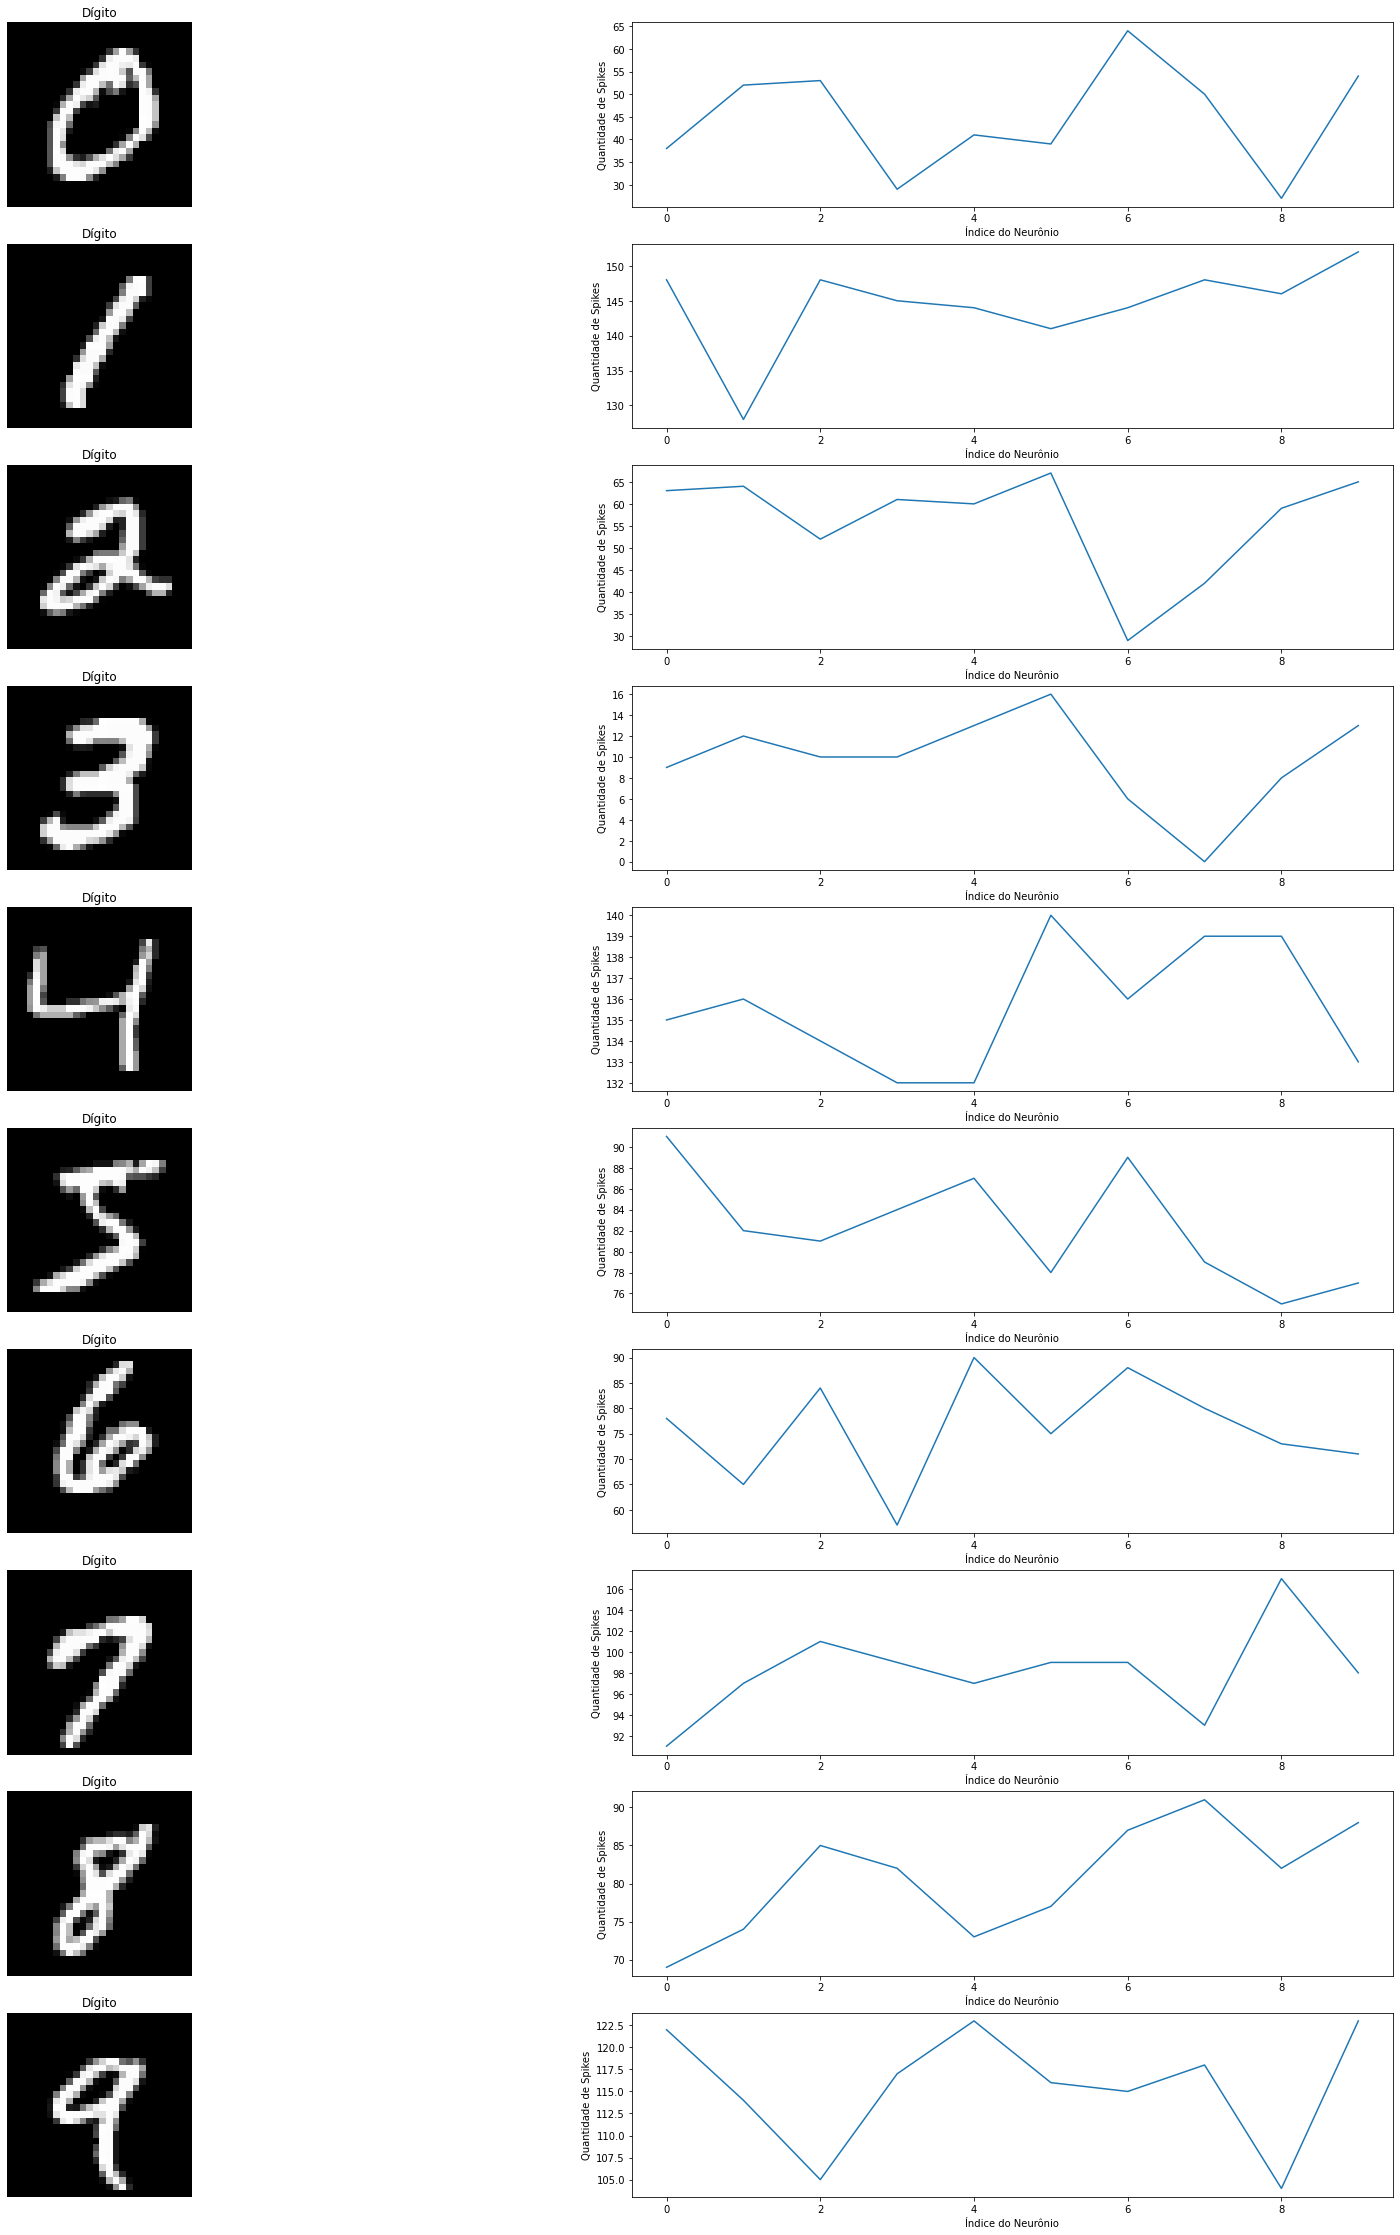

In [11]:
if (num_neurons == 1):
    spkViz.printSpikeViz(spike_obj=spike_count, 
                     x_label="Neurônio",
                     y_label="Quantidade de Spikes",
                     by_neuron=True, neuron_idx=0)
                    
else:
    spkViz.printSpikeViz(spike_obj=spike_count, 
                        x_label="Índice do Neurônio",
                        y_label="Quantidade de Spikes",
                        by_neuron=False )
                    

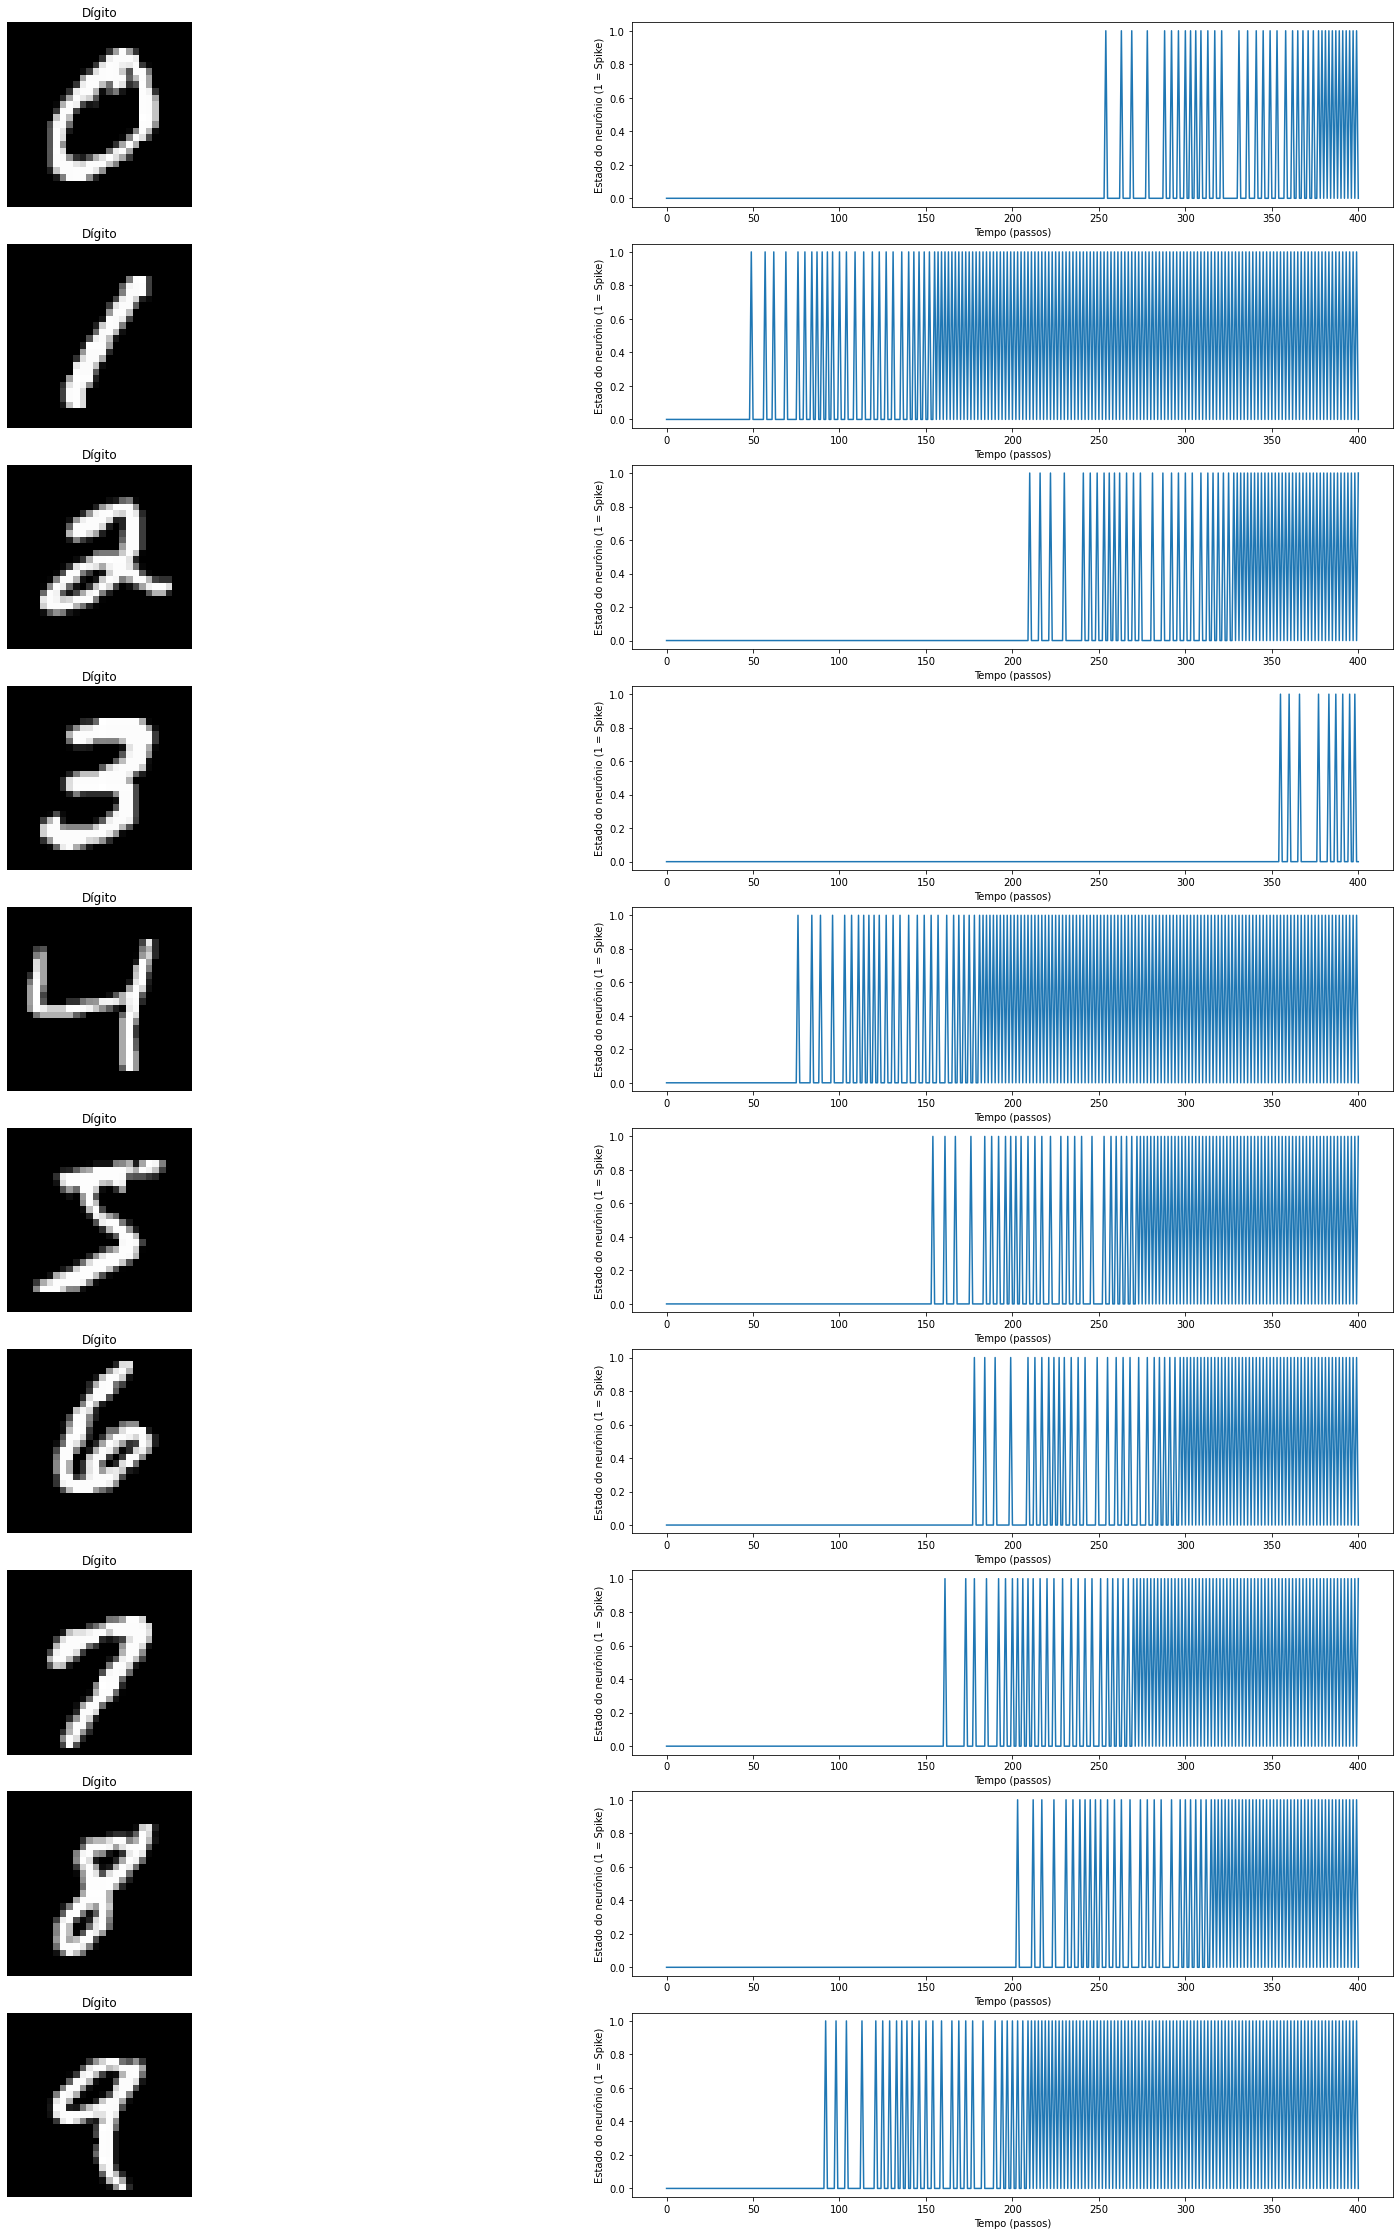

In [12]:
spkViz.printSpikeViz(spike_obj=spike_train, 
                     x_label="Tempo (passos)",
                     y_label="Estado do neurônio (1 = Spike)",
                     by_neuron= True,
                     neuron_idx = 0)

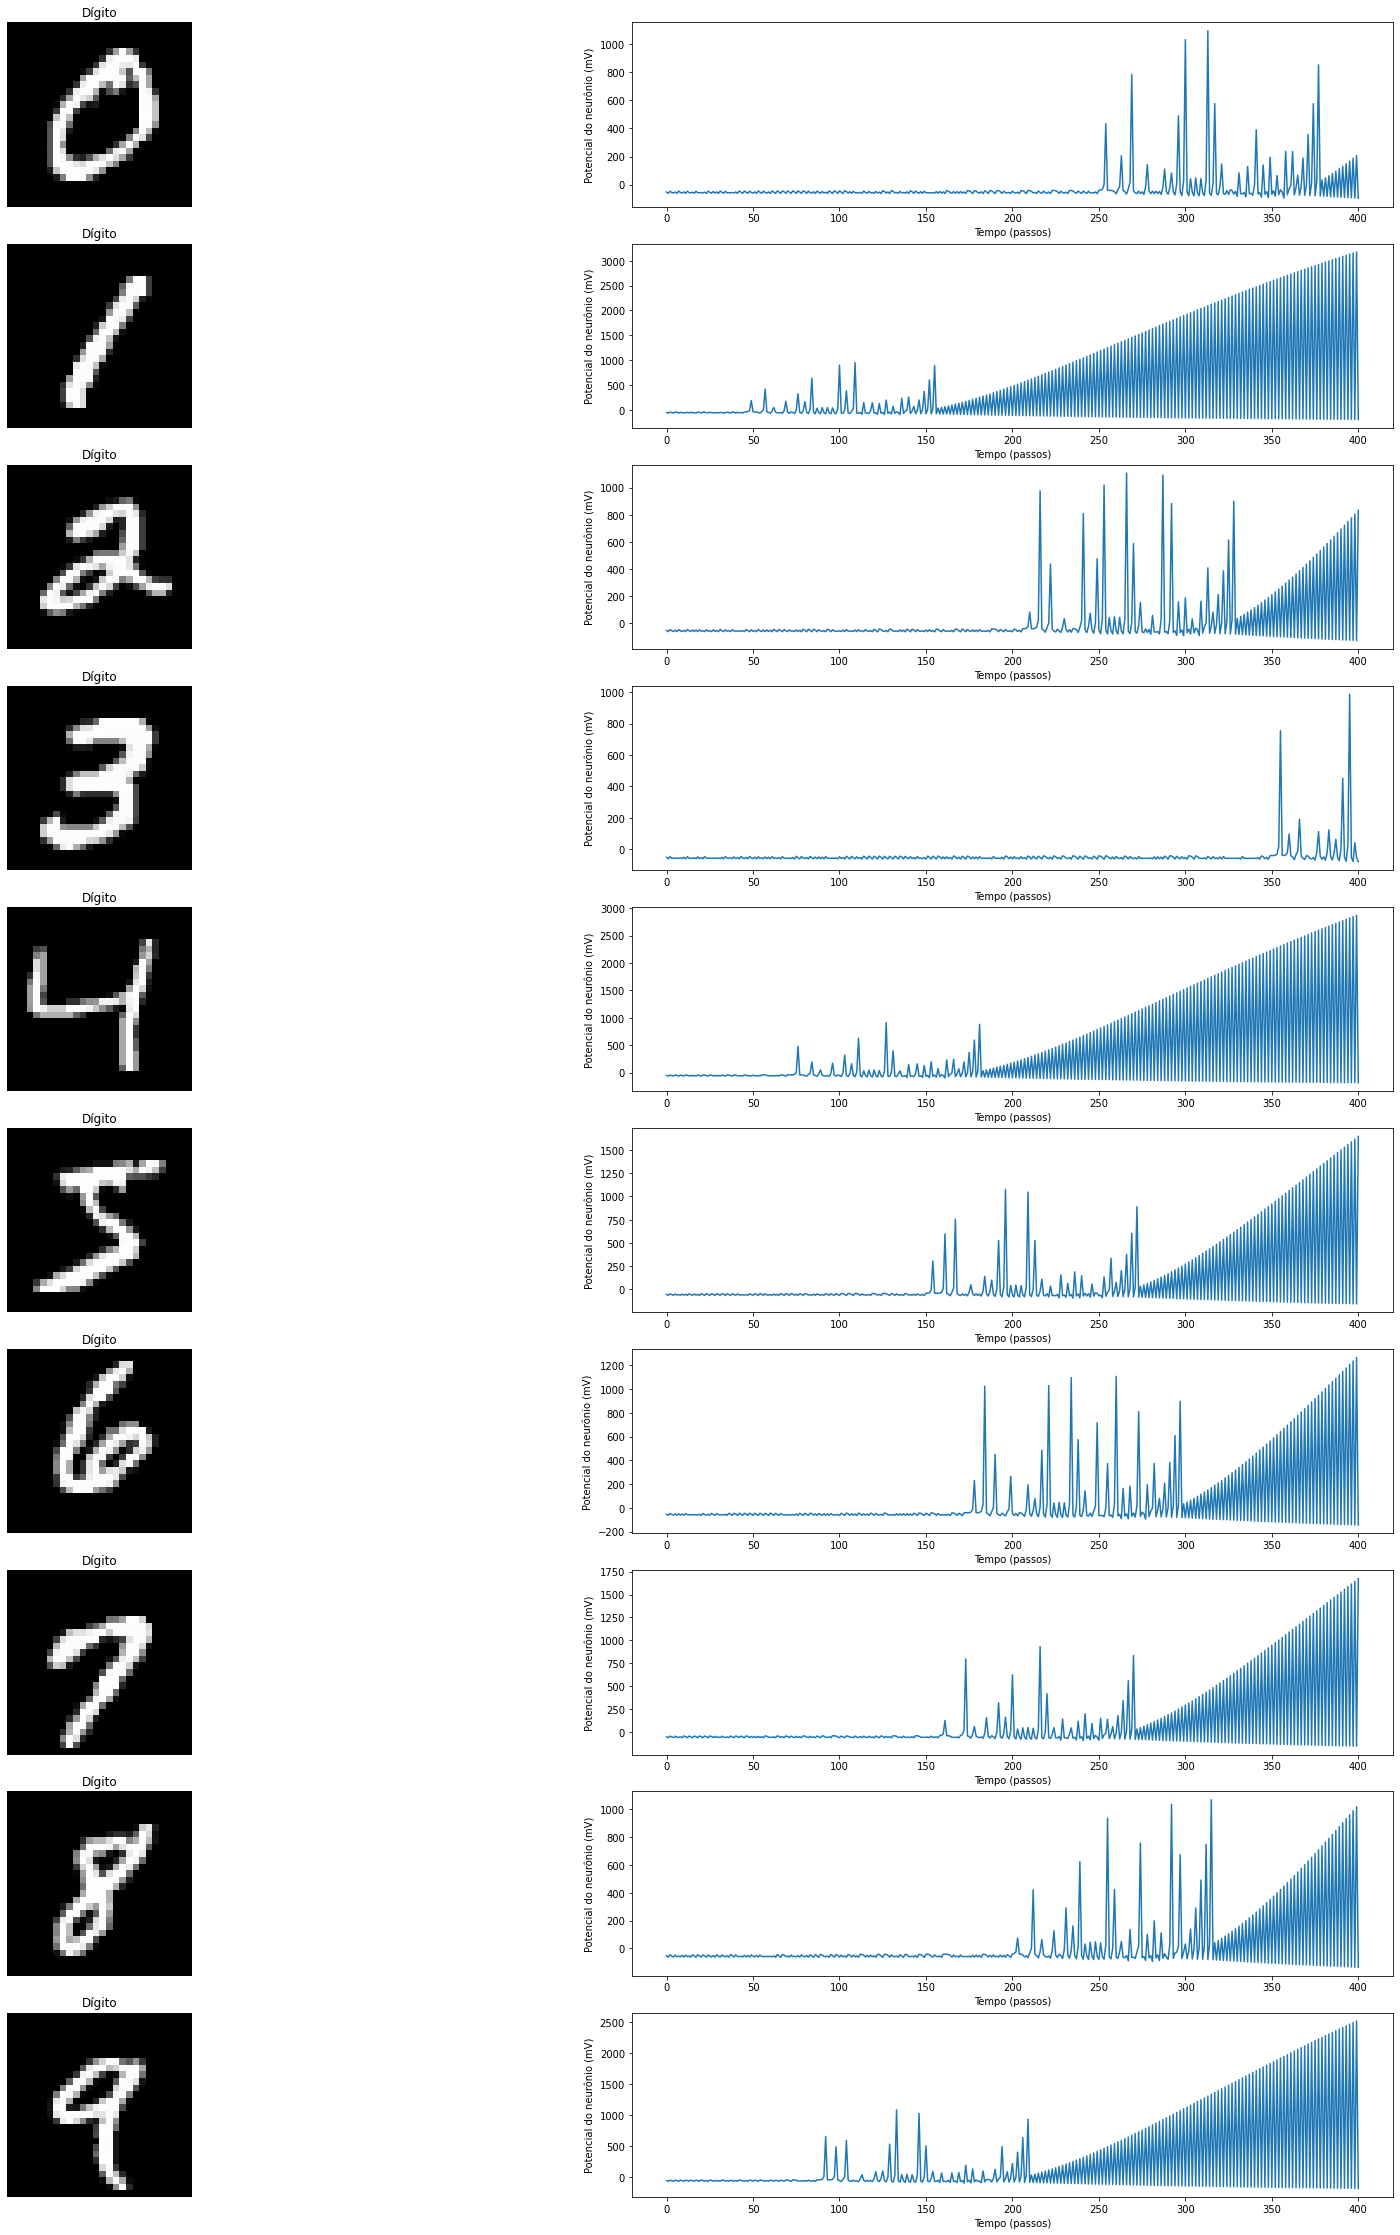

In [13]:
spkViz.printSpikeViz(spike_obj=neurons_pot, 
                     x_label="Tempo (passos)",
                     y_label="Potencial do neurônio (mV)",
                     by_neuron= True, 
                     neuron_idx = 0)

## Adaptação dos pesos sinápticos utilizando a equação de Lagrange:
$ \Delta W = \beta.(Im(i,j) - n_{i}.W) $

In [14]:
beta = 0.0001
for label in range(num_labels):
    for pattern in range(num_patterns):
        for neuron in range(num_neurons):
            for patch in range(ipp.patches_ds.shape[2]):
                for i in range(ipp.patch_size):
                    for j in range(ipp.patch_size):
                        deltaW = beta*(patches_per_label[label][pattern][patch][i][j] - spike_count[label][pattern][neuron]*W[label][pattern][neuron][patch][i][j])
                        W[label][pattern][neuron][patch][i][j] += deltaW

## Recálculo das intensidades, correntes e spikes:

In [15]:
intensity_per_neuron = np.zeros((num_labels, num_patterns, num_neurons))
gama = 0.1

for label in range(num_labels):
    for pattern in range(num_patterns):
        for neuron in range(num_neurons):
            total_int = 0
            for patch in range(ipp.patches_ds.shape[2]):
                patch_int = 0
                for i in range(ipp.patch_size):
                    for j in range(ipp.patch_size):
                        patch_int += patches_per_label[label][pattern][patch][i][j]*W[label][pattern][neuron][patch][i][j]
                total_int += gama*patch_int
                patch_int = 0
            intensity_per_neuron[label][pattern][neuron] = total_int

currents_per_neuron = np.zeros((num_labels, num_patterns, num_neurons, timeline.shape[0]))
for label in range(num_labels):
    for pattern in range(num_patterns):
        for neuron in range(num_neurons):
            for time_step in range(timeline.shape[0]):
                currents_per_neuron[label][pattern][neuron][time_step] = intensity_per_neuron[label][pattern][neuron]

neuron_layer = []
for i in range(num_neurons):
    neuron_layer.append(Izhikevich(neuron_type='RS'))

spike_train = np.zeros((num_labels, num_patterns, num_neurons, timeline.shape[0]))
spike_count = np.zeros((num_labels, num_patterns, num_neurons))
neurons_pot = np.zeros((num_labels, num_patterns, num_neurons, timeline.shape[0]))

for label in range(num_labels):
    for pattern in range(num_patterns):
        for neuron in range(num_neurons):
            I = currents_per_neuron[label][pattern][neuron]
            sc = neuron_layer[neuron].spikeResponse(I, dt, spike_train[label][pattern][neuron], neurons_pot[label][pattern][neuron])
            spike_count[label][pattern][neuron] = sc
            neuron_layer[neuron].setNeuronBaseProperties()

## Visualização dos Resultados após rejuste dos pesos:

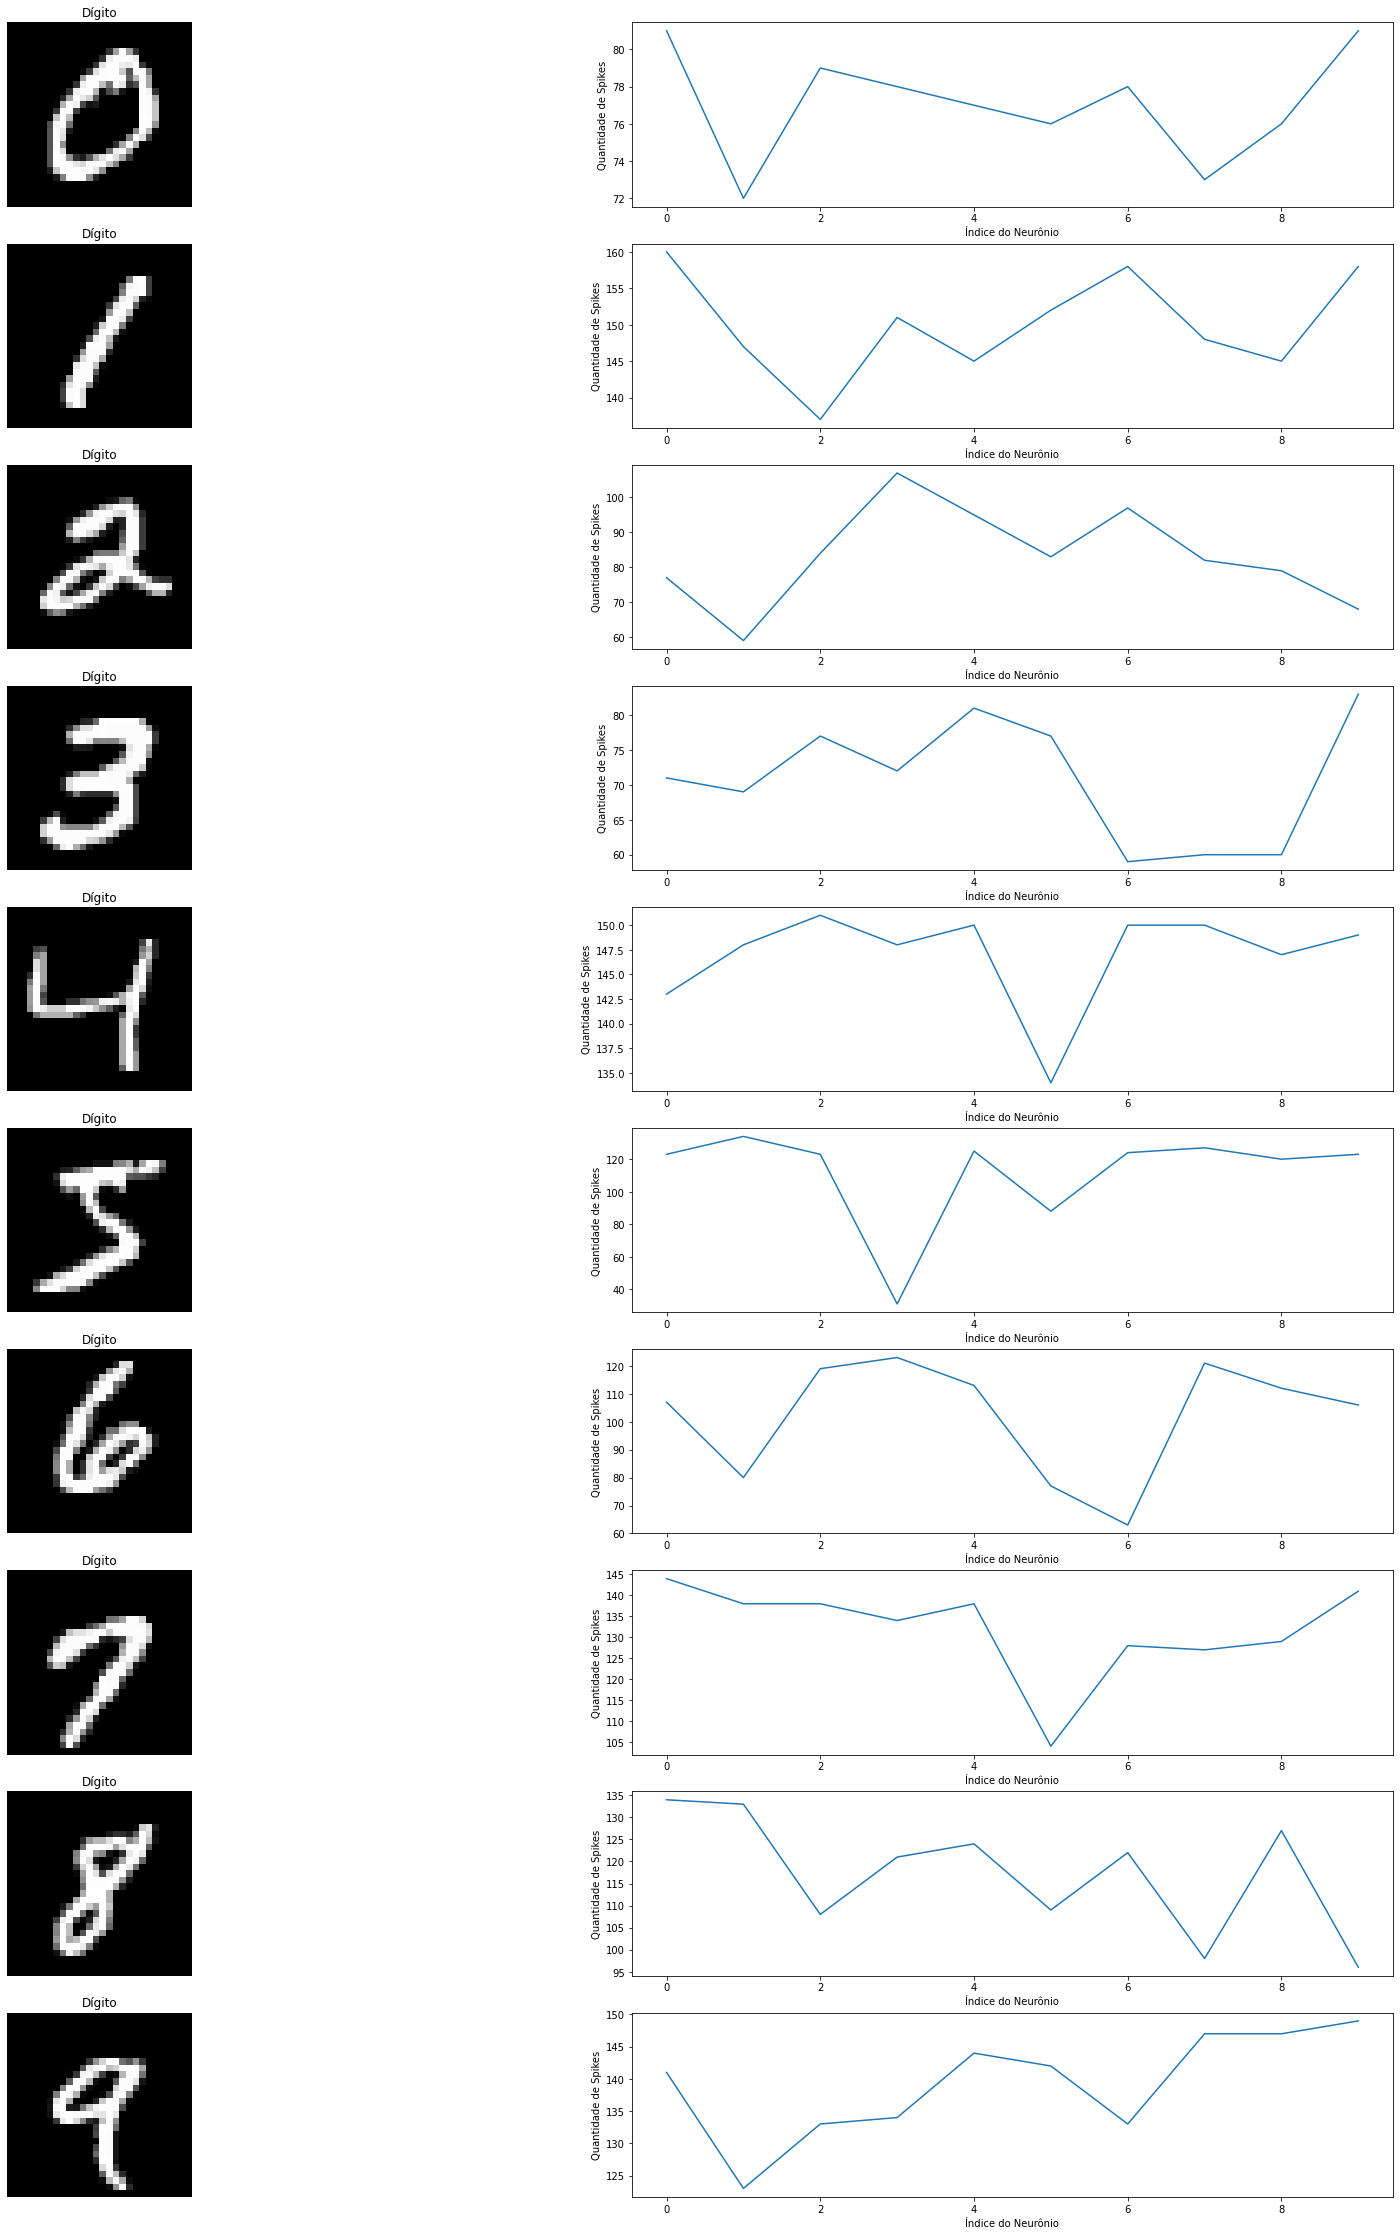

In [16]:
spkViz.printSpikeViz(spike_obj=spike_count, 
                     x_label="Índice do Neurônio",
                     y_label="Quantidade de Spikes",
                     by_neuron= False)

In [17]:
spkViz.printSpikeViz(spike_obj=spike_train, 
                     x_label="Tempo (passos)",
                     y_label="Estado do neurônio (1 = Spike)",
                     by_neuron= True,
                     neuron_idx = 50)

IndexError: index 50 is out of bounds for axis 0 with size 10

In [ ]:
spkViz.printSpikeViz(spike_obj=neurons_pot, 
                     x_label="Tempo (passos)",
                     y_label="Potencial do neurônio (mV)",
                     by_neuron= True, 
                     neuron_idx = 50)